In [11]:
import numpy as np
import pandas as pd
import re
from scipy.integrate import odeint
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16.,8.)

## Class Approximator

In [77]:
def form_discrete_values(funcs, y, orders):
    """ @Parameters:
        1) funcs - contains an array of lambdas, to be applied to columns
        2) y - a column with output values
        3) orders - an array of integers, used to refer to lagging (for example, orders = 2, means, that
        the column is considered to be y[t - 2])
    """
    x = np.array([[func(y[t - order, 0]) for func, order in zip(funcs, orders)] for t in range(orders[0], y.shape[0])])
    return np.hstack((x, y[orders[0]:]))


class Approximator(object):
    """ @Parameters:
        1) data - a table, where first columns are features and the last one is output
        2) teta - unknown parameters to be evaluated
        3) variance - unknown variance to be found
        This class is used to get linear approximation (using OMNK algo) and
        to calculate thereby variance, Akaike and Mallows coefficients
    """
    def __init__(self, data):
        self.data = data
        self.teta = None
        self.variance = 0
        self.factors = None
        self.RMSs = 0
        self.RSSs = []
        self.Akaikes = []
        self.Mallowss = []
        
    def get_tetas(self, factors, verbose=False):
        """ @Parameters:
            1) factors - represents amount of factors to be accounter into (might not exceed the
            size of the self.data)
            This function implements OMNK algorithm, which recursively evaluates unknown coefficients
            by gradually adding columns to  X.T@X matrix and therefore requiring as much as there are
            columns present to complete. At the same time variance is also evalueted recursively
        """
        
        if verbose:
            print("Step " + str(1) + " :")
        
        n, m = self.data.shape
        Hs = np.array([[(self.data[:, 0].T @ self.data[:, 0])]])
        h = np.array([[self.data[:, 0] @ self.data[:, 1]]])
        eta = np.array([[self.data[:, 0].T @ self.data[:, 0]]])
        Hs_inv = np.linalg.inv(Hs)
        teta = [self.data[:, :1].T @ self.data[:, -1] / (self.data[:, :1].T @ self.data[:, :1])]
        P = np.eye(n) - (self.data[:, :1] @ np.linalg.inv(self.data[:, :1].T 
                                          @ self.data[:, :1]) @ self.data[:, :1].T)   
        variance = self.data[:, -1].T @ P @ self.data[:, -1]

        if verbose:
            print("parameters are: ")
            print(teta[0][0][0])
            
        self.factors = 1
        self.variance = variance
        self.RSSs.append(variance)
        self.Akaikes.append(self.get_Akaike())
        self.Mallowss.append(self.get_Mallows())
        
        for i in range(1, factors):
            if verbose:
                print("Step " + str(i + 1) + " :")
            h = np.array([self.data[:, :i].T @ self.data[:, i]])
            eta = np.array([[self.data[:, i].T @ self.data[:, i]]])
            
            Hs_1 = Hs
            Hs_2 = h.T
            Hs_3 = h
            Hs_4 = eta
            beta = eta - h @ Hs_inv @ h.T
            D = np.eye(n) - self.data[:, :i] @ Hs_inv @ self.data[:, :i].T
            coefficient = self.data[:, i].T @ D @ self.data[:, i]
            
            Hs = np.hstack((np.vstack((Hs_1, Hs_3)), np.vstack((Hs_2, Hs_4))))
            
            Hs_inv_1 = Hs_inv + (1 / beta) * Hs_inv @ h.T @ h @ Hs_inv
            
            Hs_inv_2 = -(1 / beta) * Hs_inv @ h.T
            Hs_inv_3 = -(1 / beta) * h @ Hs_inv
            Hs_inv_4 = (1 / beta)
            
            Hs_inv = np.hstack((np.vstack((Hs_inv_1, Hs_inv_3)), np.vstack((Hs_inv_2, Hs_inv_4))))
            gs = np.hstack((self.data[:, :i].T @ self.data[:, -1], self.data[:, i].T @ self.data[:, -1]))
            
            teta = Hs_inv @ gs
            variance -= (teta[-1] ** 2) * beta
            variance = variance[0][0]
            self.factors += 1
            self.variance = variance
            self.RSSs.append(variance)
            self.Akaikes.append(self.get_Akaike())
            self.Mallowss.append(self.get_Mallows())
            if verbose:
                print("parameters are: ")
                print(teta)
        self.teta = teta
        return teta
    
    def get_variance(self):
        return self.variance
    
    def get_sigma_evaluation(self):
        n, m = self.data.shape
        s = self.factors
        return self.variance / (n - s)
    
    def get_Mallows(self):
        s = self.factors
        return self.variance + 2 * s
    
    def get_Akaike(self):
        n, m = self.data.shape
        s = self.factors
        return self.variance * ((n + s)/ (n - s))
    
    def get_params(self, formulas):
        params = list(map(lambda formula: formula(self.teta), formulas))
        return params

## Class Model

In [3]:
class Model:
    def __init__(self, system, name):
        self.system = system
        self.name = name
        self.solved = None
        self.time_points = None
        self.initial_condition = None
        self.params = None
    
    def get_values(self, step):
        data = self.solved[:, 0][::step]
        return data.reshape((data.shape[0], 1))
    
    def build(self, params, initial_condition, time_points):
        self.params = params
        self.time_points = time_points
        self.initial_condition = initial_condition
        self.solved = odeint(self.system, initial_condition, time_points, args=tuple(self.params.values()))
            
    def get_data(self, index):
        if index == 0:
            return pd.DataFrame({'t': self.time_points, 'X(t)': self.solved[:, 0]})
        if index == 1:
            return pd.DataFrame({'t': self.time_points, 'Y(t)': self.solved[:, 1]})
        else:
            return pd.DataFrame({'X': self.solved[:, 0], 'Y': self.solved[:, 1]})
    
    def plot(self, plot_y=True):
        plt.figure(0)
        plt.plot(self.time_points, self.solved[:, 0])
        if plot_y:
            plt.plot(self.time_points, self.solved[:, 1])
        params = re.findall("[^}'{']", str(re.sub(': ', '=', str(self.params))))
        plt.title(self.name + ' with params: \n' +  ''.join(params), fontsize=15)
        plt.xlabel('t', fontsize=15)
        plt.ylabel('X(t)', fontsize=15)
    
    
    def phase_plot(self):
        plt.figure(1)
        plt.xlabel('X', fontsize=15)
        plt.ylabel('Y', fontsize=15)
        plt.scatter(self.solved[0,0], self.solved[0, 1])
        plt.plot(self.solved[:,0], self.solved[:, 1], color='orange')
        plt.title(self.name + ' ' + 'phase plot\n', fontsize=15)
        

## Class Verhulst_Approximator

In [4]:
import seaborn as sns
def Verhulst(z, t, r, k):
    dx_dt = r * z[0] * (k - z[0])
    dy_dt = 0 
    return dx_dt, dy_dt

verhulst_params = {
    'r':  0.1, 
    'k': 5.
}

verhulst_initial_condition=(.1, 0)

class Verhulst_Approximator:
    def __init__(self, 
                 verhulst_params,
                 verhulst_initial_condition,
                 noise=0,
                 step= 1,
                 step_diff=10,
                 t_begin=0,
                 t_end=20,
                ):
        self.verhulst_params = verhulst_params
        self.verhulst_initial_condition = verhulst_initial_condition
        self.noise = noise
        self.step = step
        self.step_diff = step_diff
        self.t = np.arange(t_begin, t_end + 2, self.step / self.step_diff)
        self.data = self.extract_verhulst_features()
        self.pred_params = None
        self.real = None
    
    def extract_verhulst_features(self):
        self.real = Model(Verhulst, 'Verhulst')
        self.real.build(self.verhulst_params, self.verhulst_initial_condition, self.t)
        out = self.real.solved[:,0] #+ np.random.normal(0, 0.2, len(self.real.solved[:,0]))
        theta = np.array([self.verhulst_params['r'] * self.verhulst_params['k'] + 1/self.step, - self.verhulst_params['r']])
        data = {
            't': self.t[0::self.step_diff][:-1],
            'N(t)': out[0::self.step_diff][:-1],
            'N^2(t)': np.square(out[0::self.step_diff][:-1]),
            'N(t+{})'.format(self.step):  np.round(out[0::self.step_diff][1:], self.noise)
        }
        return pd.DataFrame(data=data)
    
    def run(self, verbose=True):
        solver = Approximator(self.data.to_numpy()[:, 1:])
        tetas = solver.get_tetas(2, verbose=verbose)
        
        def findparams(theta1, theta2):
            r = - theta2 / self.step
            k = (1 - theta1) / theta2
            return {'r': r, 'k': k }
        
        pred_params = findparams(tetas[0], tetas[1])
        
        if verbose:
            print(verhulst_params)
            print(pred_params)
            
        model = Model(Verhulst, 'Verhulst')
        model.build(pred_params, self.verhulst_initial_condition, self.data['t'])
        if verbose:
            model.plot(plot_y=False)
            self.real.plot(plot_y=False)
            sns.scatterplot(self.data['t'], self.data['N(t)'], color='brown')
            plt.title('Approximation')
            #plt.plot(np.arange(len(model.solved[0])), model.solved[0])
            plt.legend(['Наближення динаміки популяції', 'Динаміка популяції', 'Навчальна вибірка'])
            plt.xlabel('t', fontsize=15)
            plt.ylabel('X(t)', fontsize=15)
        
        self.pred_params = pred_params
        
        return self.data
    
    def get_error(self):
        return {param: abs(self.verhulst_params[param] - self.pred_params[param]) \
                for param in self.verhulst_params.keys()}

In [5]:
def form_noise_step_dependancy(steps, noises, params):
    dependancies = dict()
    
    for param in list(params.keys())[: 2]:
        dependancies[param] = pd.DataFrame({str('noise= ') + str(noise): [] for noise in noises})
        
    
    for step in steps:
        
        step_rows = {param: [] for param in params}
        
        for noise in noises:
            test = Oscilate_Approximator(params, verhulst_initial_condition, step=step, noise=noise)
            test.run(verbose=False)
            
            for param in list(params.keys())[: 2]:
                step_rows[param].append(test.pred_params[param])
        
        for param in list(params.keys())[: 2]:
            dependancies[param].loc[len(dependancies[param])] = step_rows[param]
     
    for param in list(params.keys())[: 2]:
        dependancies[param].index = steps
        
    return dependancies
        
        
            
#params = form_noise_step_dependancy([4, 1, 0.4], [1, 2, 3], {'delta': 0.1, 'omega_0': 5, 'omega': 5, 'f': 0})
test = Verhulst_Approximator(verhulst_params, verhulst_initial_condition)
test.extract_verhulst_features()



,t,N(t),N^2(t),N(t+1)
0,0.0,0.100000,0.010000,0.0
1,1.0,0.162760,0.026491,0.0
2,2.0,0.262797,0.069062,0.0
3,3.0,0.418993,0.175555,1.0
4,4.0,0.655185,0.429267,1.0
5,5.0,0.995586,0.991192,1.0
6,6.0,1.453671,2.113160,2.0
7,7.0,2.016395,4.065851,3.0
8,8.0,2.635092,6.943712,3.0
9,9.0,3.237627,10.482228,4.0


## Class Oscilate_Approximator

In [89]:
import seaborn as sns
def oscilation(z, t, delta, omega_0, omega, f):
    dx_dt = z[1]
    dy_dt = -2 * delta * z[1] - omega_0 ** 2 * z[0] + f * np.cos(omega * t)  
    return dx_dt, dy_dt

oscilate_params = {
    'delta': 0.15, 
    'omega': 1.,
    'omega_0': 0.,
    'f': 0.
}

oscilate_initial_condition=(0.5,0.)

class Oscilate_Approximator:
    def __init__(self, 
                 oscilate_params,
                 oscilate_initial_condition,
                 noise=7,
                 step=1.,
                 step_diff=10000,
                 t_begin=0,
                 t_end=22
                ):
        self.oscilate_params = oscilate_params
        self.oscilate_initial_condition = oscilate_initial_condition
        self.noise = noise
        self.step = step
        self.step_diff = step_diff
        self.t = np.arange(t_begin, t_end + 3 , self.step / self.step_diff) ## changes
        self.data = self.extract_oscilation_features()
        self.pred_params = None
        self.real = None
    
    def extract_oscilation_features(self):
        self.real = Model(oscilation, 'Oscilation')
        self.real.build(self.oscilate_params, self.oscilate_initial_condition, self.t)
        out = self.real.solved[:,0] #+ np.random.normal(0, 0.05, len(self.real.solved[:,0])) 
        theta = np.array([(2 - 2 * self.oscilate_params['delta'] - (self.oscilate_params['omega']**2) * self.step**2) / 
                          (1 - 2 * self.oscilate_params['delta'] * self.step),
                         1 / (2 * self.oscilate_params['delta'] * self.step - 1)])
        data = {
            't': self.t[0::self.step_diff][:-2],
            'x(t)': out[0::self.step_diff][:-2],
            'x(t+{})'.format(self.step):  out[0::self.step_diff][1:-1],
            'x(t+{})'.format(self.step*2):  np.round(out[0::self.step_diff][2:], self.noise) # np.round(np.array([out[0::step*100][:-1], out[0::step*100][1:]]).T @ theta, noise)
        }
        return pd.DataFrame(data=data)

    def run(self, verbose=True):
        solver = Approximator(self.data.to_numpy()[:,1:])
        tetas = solver.get_tetas(2, verbose=verbose)
        
        def findparams(theta2, theta1):
            delta =  -((1 / theta2) + 1) / (2 * self.step)
            omega = np.sqrt(((-1*theta1 * (1 - 2 * delta * self.step) + 2 - 2 * delta) / self.step**2)) 
           
            return {'delta': delta, 'omega_0': omega, 'omega': 0., 'f': 0.}
        
        pred_params = findparams(tetas[0], tetas[1])
        self.pred_params = pred_params
        
        if verbose:
            print(oscilate_params)
            print(pred_params)
            model = Model(oscilation, 'Oscilation')
            model.build(pred_params, self.oscilate_initial_condition, self.real.time_points)
            model.plot(plot_y=False)
            self.real.plot(plot_y=False)
            sns.scatterplot(self.data['t'][:-int(2/self.step)], 
                            self.data['x(t)'.format(self.step)][:-int(2/self.step)], color='black')
            plt.legend(['Наближення гармонічних коливань', 'Гармонічні коливання', 'Навчальна вибірка'])
            plt.title('Approximation')
            plt.xlabel('t', fontsize=15)
            plt.ylabel('X(t)', fontsize=15)

        return self.data
        
    def get_error(self):
        return {param: abs(self.oscilate_params[param] - self.pred_params[param]) \
                for param in self.oscilate_params.keys()}

Step 1 :
parameters are: 
-0.3116140321106622
Step 2 :
parameters are: 
[-0.7408182   0.94641364]
{'delta': 0.15, 'omega': 1.0, 'omega_0': 0.0, 'f': 0.0}
{'delta': 0.17492942119635813, 'omega_0': 1.0172702173584327, 'omega': 0.0, 'f': 0.0}


,t,x(t),x(t+1.0),x(t+2.0)
0,0.0,0.500000,0.291142,-0.094868
1,1.0,0.291142,-0.094868,-0.305468
2,2.0,-0.094868,-0.305468,-0.218819
3,3.0,-0.305468,-0.218819,0.019203
4,4.0,-0.218819,0.019203,0.180279
5,5.0,0.019203,0.180279,0.156393
6,6.0,0.180279,0.156393,0.014458
7,7.0,0.156393,0.014458,-0.102175
8,8.0,0.014458,-0.102175,-0.107411
9,9.0,-0.102175,-0.107411,-0.025962


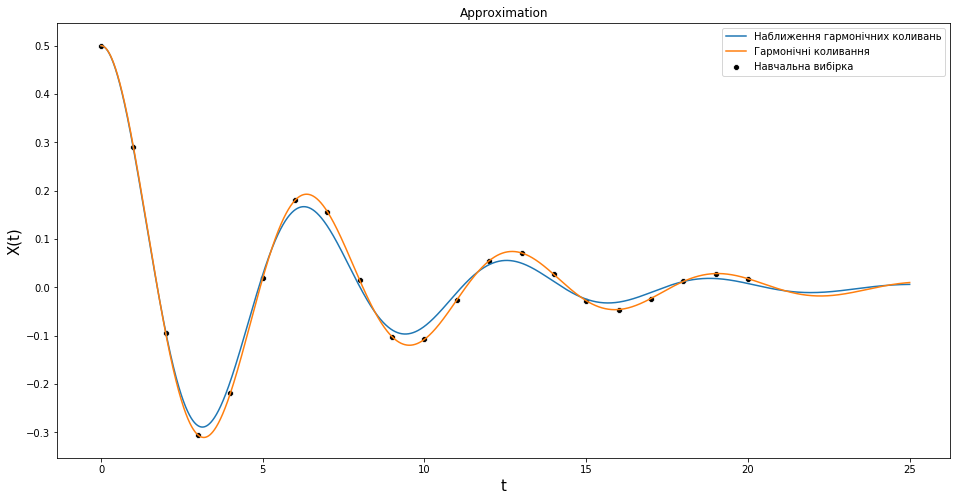

In [90]:
osc = Oscilate_Approximator(oscilate_params, oscilate_initial_condition)
osc.extract_oscilation_features()
osc.run(verbose=True)

## Task Generator

In [140]:
class Generator:
    def __init__(self, n, X=None , noise=0.5, theta=np.random.randint(-10,10,5) ): 
        self.X = X
        self.n = n
        self.theta = theta
        self.noise = np.random.normal(0, noise, n) 
        self.sigma = noise
        self.y = self.X @ self.theta + self.noise
        self.df = pd.DataFrame()
        
    def run(self, verbose=True): 
        if verbose:
            print('n = {}'.format(self.X.shape[0])) 
            print('m = {}'.format(self.X.shape[1])) 
            print('sigma = {}'.format(self.sigma)) #print('X:{}'.format(self.X)) #print('y:{}'.format(self.y))
        solver = Approximator(np.vstack((self.X.T, self.y.T)).T) 
        tetas = solver.get_tetas(self.X.shape[1], True) 
        plt.figure()
        plt.plot(np.arange(1, len(solver.RSSs) + 1), solver.RSSs, color = 'black') 
        plt.plot(np.arange(1, len(solver.RSSs) + 1), solver.Akaikes)
        plt.plot(np.arange(1, len(solver.RSSs) + 1), solver.Mallowss) 
        plt.legend(['RSS', 'Akaike', 'Mallows']) 
        plt.title('Task Generator: n=' + str(self.n) + ' noise=' +str(self.sigma))
        print('True values: θ = {}'.format(self.theta)) 
        print('Estimates: θ* = {}'.format(tetas))
        self.df = pd.DataFrame(data=[solver.RSSs, solver.Akaikes, solver.Mallowss]).T
        self.df.columns=['RSS', 'Akaike', 'Mallows']
        self.df.index=np.arange(1, len(self.df)+1)


forward

n = 10
m = 5
sigma = 0
Step 1 :
parameters are: 
1.128942638643756
Step 2 :
parameters are: 
[ 2.14353431 -1.81734786]
Step 3 :
parameters are: 
[ 3. -2.  1.]
Step 4 :
parameters are: 
[ 3.00000000e+00 -2.00000000e+00  1.00000000e+00  2.49800181e-16]
Step 5 :
parameters are: 
[ 3.00000000e+00 -2.00000000e+00  1.00000000e+00  4.16333634e-16
 -2.22044605e-16]
True values: θ = [ 3. -2.  1.  0.  0.]
Estimates: θ* = [ 3.00000000e+00 -2.00000000e+00  1.00000000e+00  4.16333634e-16
 -2.22044605e-16]

backward

n = 10
m = 5
sigma = 0
Step 1 :
parameters are: 
-1.7065885640729876
Step 2 :
parameters are: 
[-2.14887895  0.79223544]
Step 3 :
parameters are: 
[-0.4136532   0.4221766   2.02603065]
Step 4 :
parameters are: 
[-0.31783153  0.56450171  2.69908622 -2.20350944]
Step 5 :
parameters are: 
[-8.88178420e-16  3.33066907e-16  1.00000000e+00 -2.00000000e+00
  3.00000000e+00]
True values: θ = [ 0.  0.  1. -2.  3.]
Estimates: θ* = [-8.88178420e-16  3.33066907e-16  1.00000000e+00 -2.0000

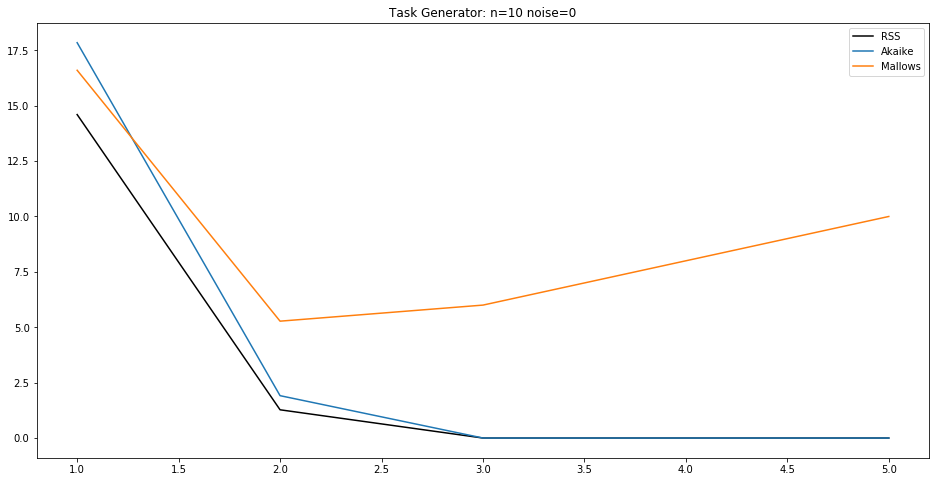

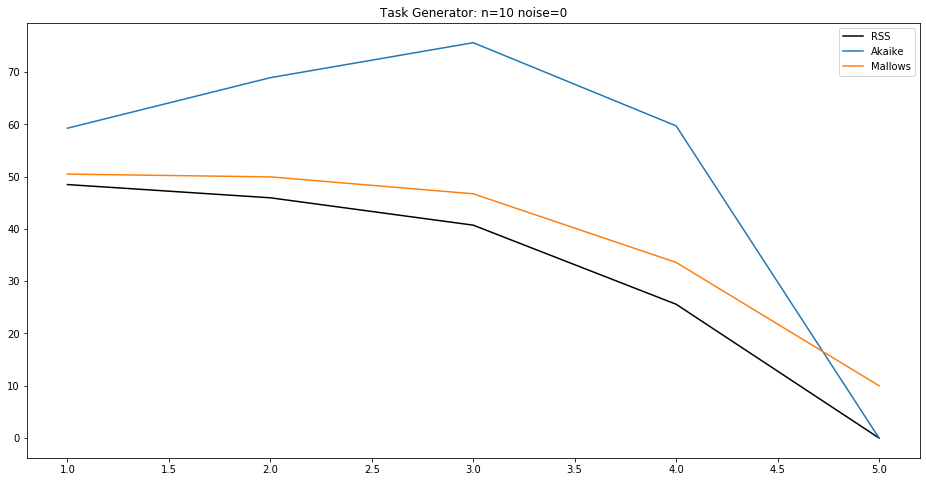

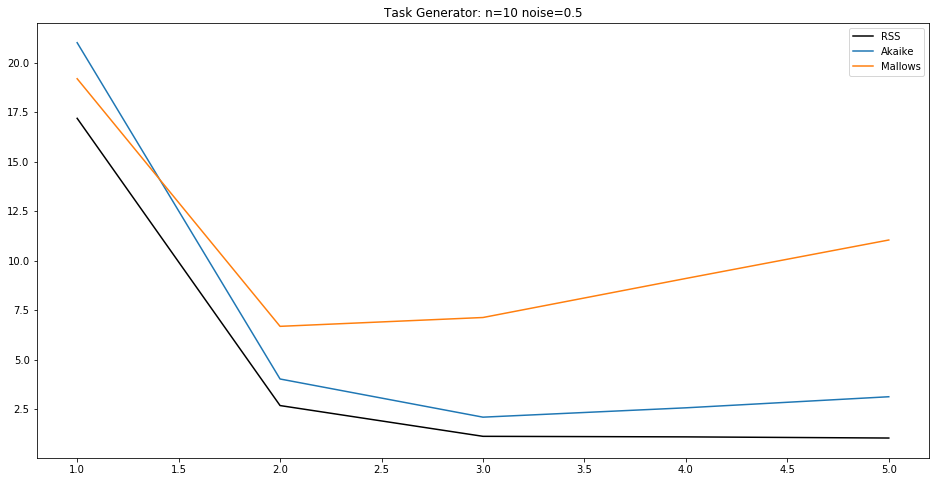

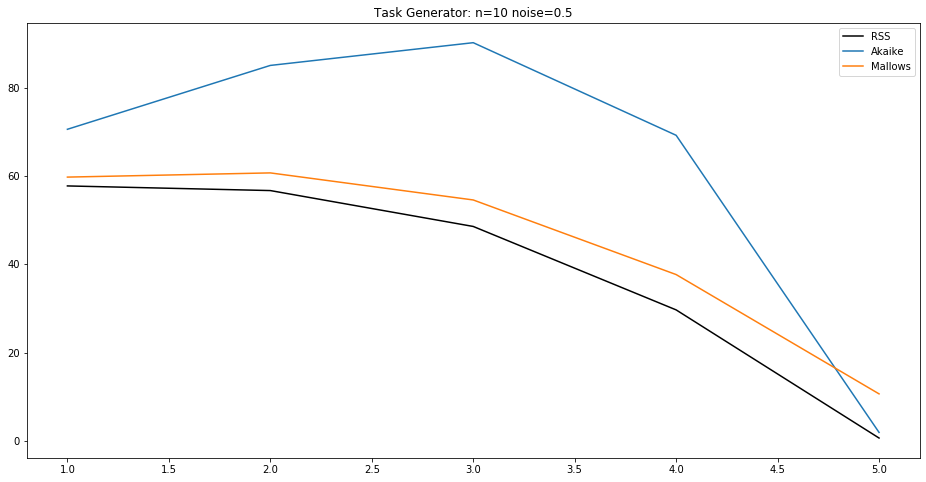

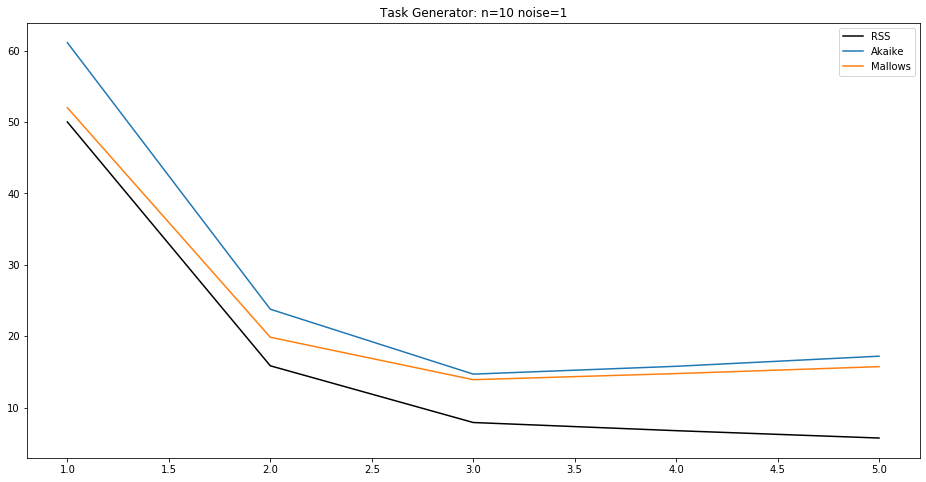

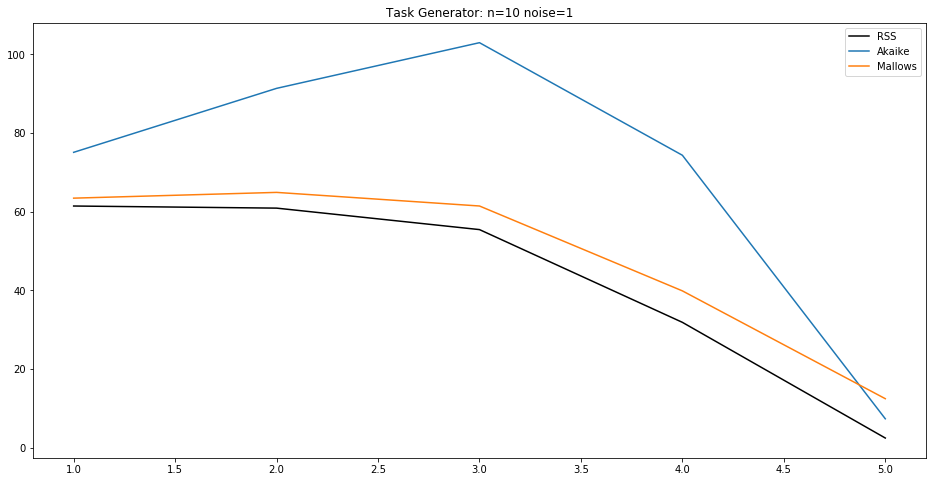

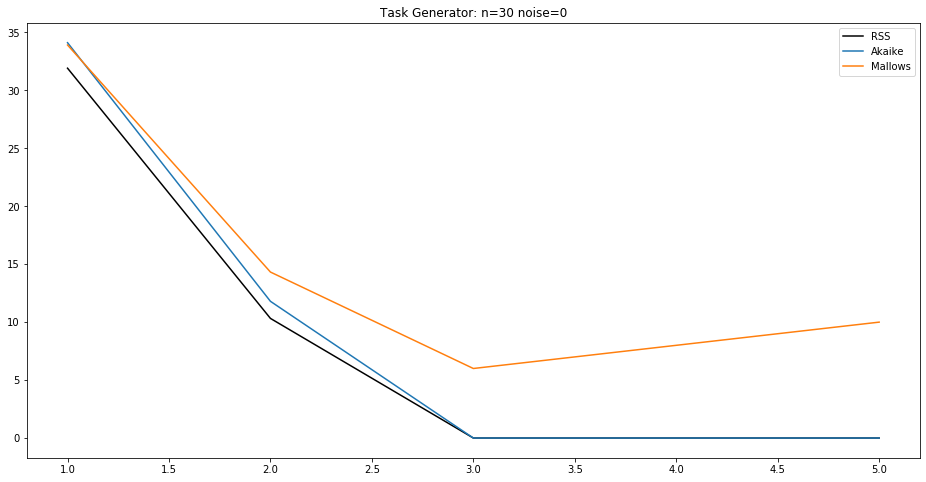

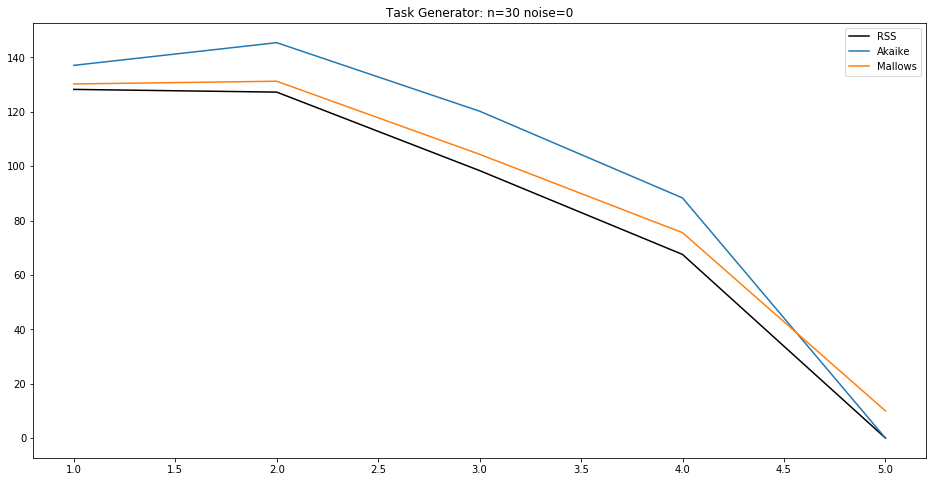

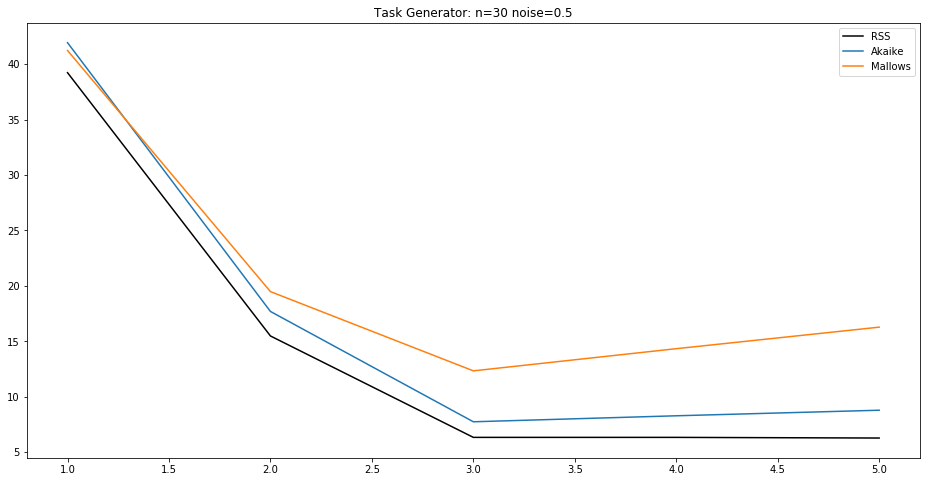

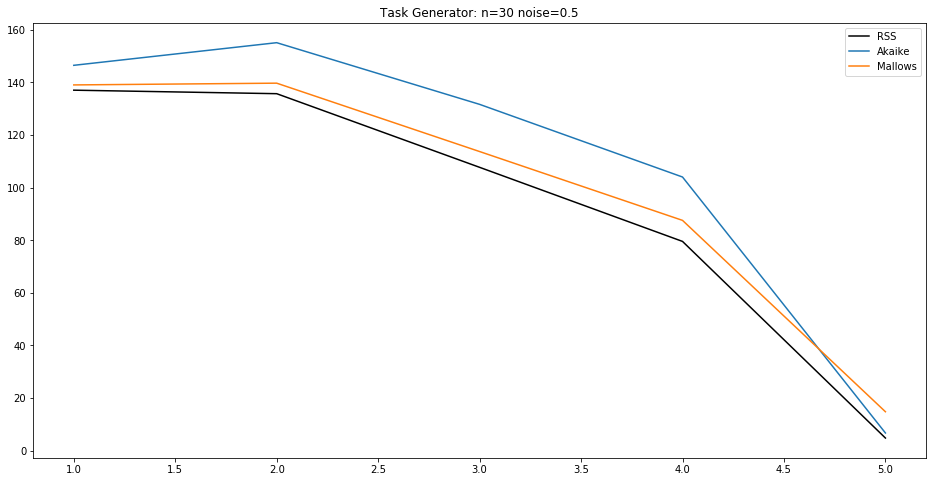

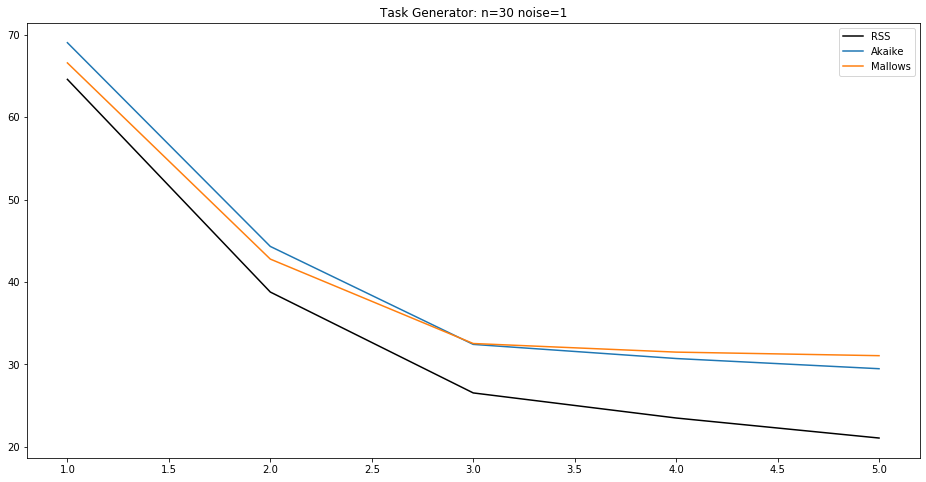

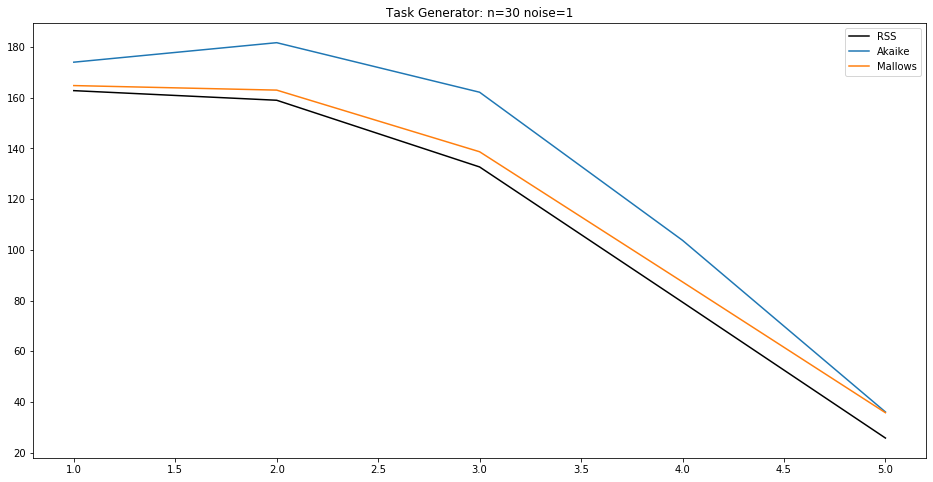

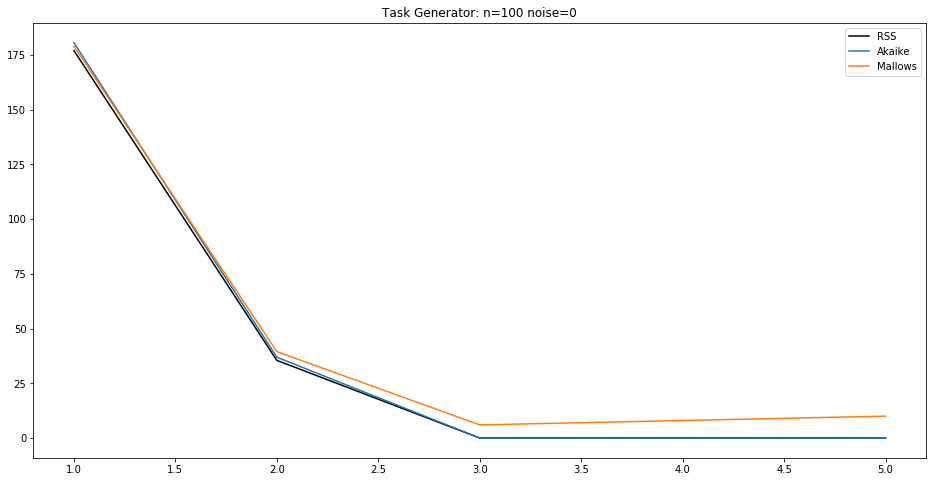

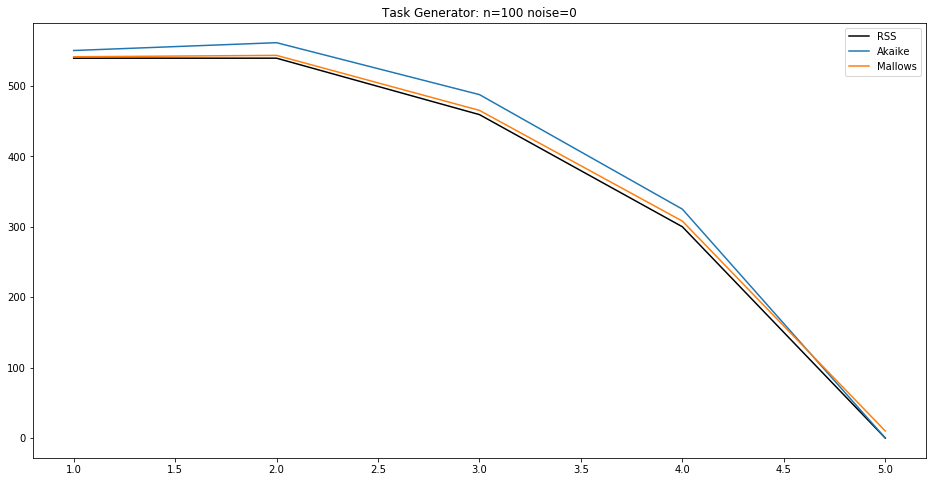

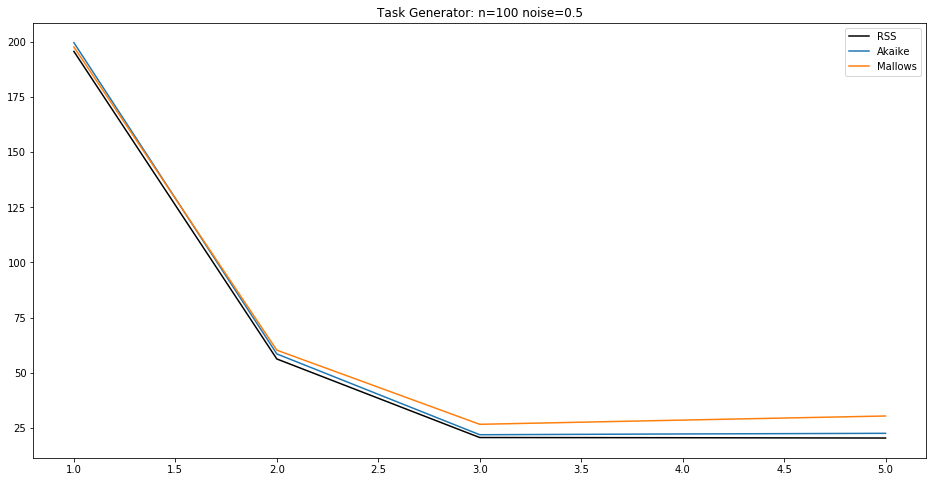

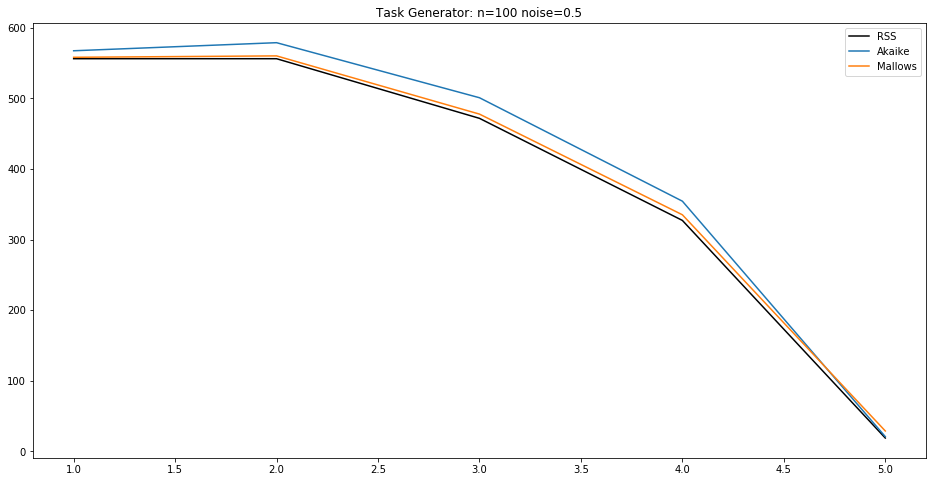

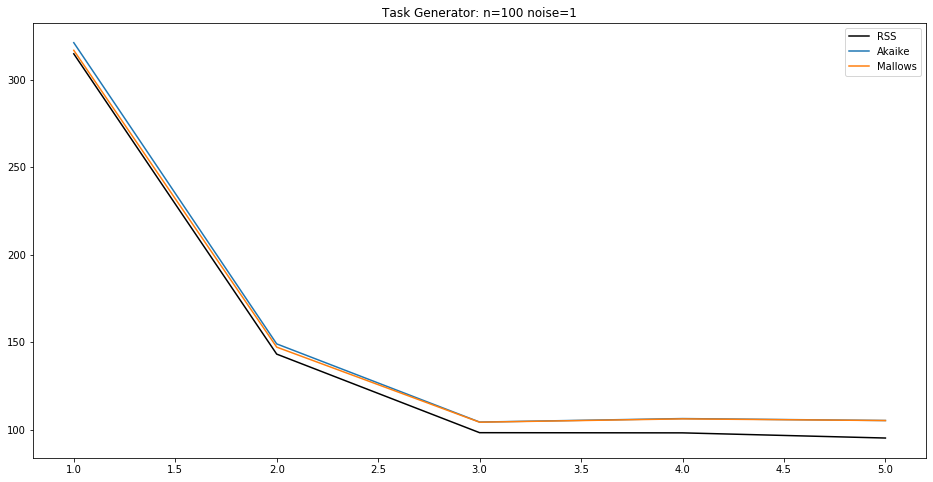

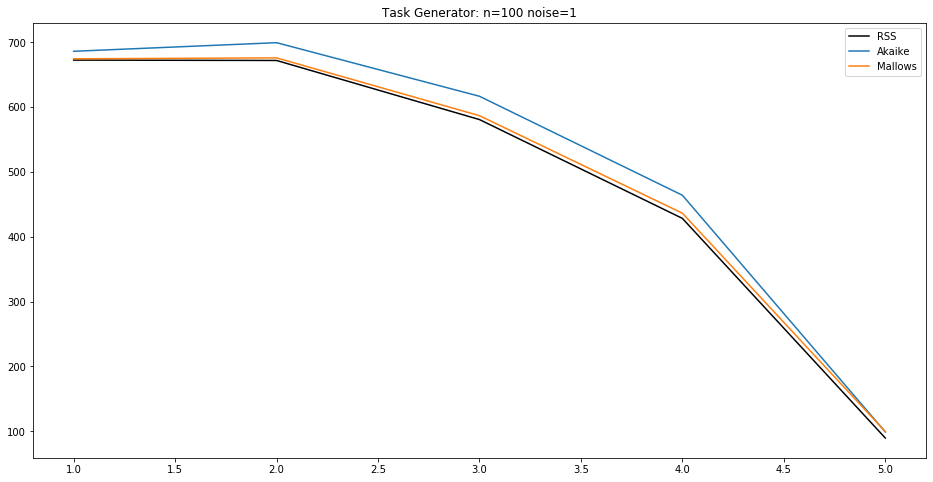

In [146]:
ns = [10,30,100]
noises = [0, 0.5, 1]
dfs = {'forward': [], 'backward': []}
thetas = [np.array([0. ,0. ,1. ,-2. ,3.]), np.array([3. ,-2. ,1. ,0. ,0.])] 
for i in ns:
    X = np.random.uniform(-1, 1, (i, 5))
    for j in noises:
        print('\nforward\n')
        gener_forward = Generator(n=i, X=X, noise=j, theta = thetas[1]) 
        gener_forward.run()
        gener_forward.df.columns=['RSS_п', 'Akaike_п', 'Mallows_п']
        dfs['forward'].append(gener_forward.df)
        print('\nbackward\n')
        gener_backward = Generator(n=i, X=X, noise=j, theta = thetas[0]) 
        gener_backward.run()
        gener_backward.df.columns=['RSS_р', 'Akaike_р', 'Mallows_р']
        dfs['backward'].append(gener_backward.df)

In [166]:
i=-1

In [175]:
i += 1
print(i)
pd.concat([dfs['forward'][i], dfs['backward'][i]], axis=1)



8


,RSS_п,Akaike_п,Mallows_п,RSS_р,Akaike_р,Mallows_р
1,314.833418,321.193689,316.833418,672.637747,686.226388,674.637747
2,143.130776,148.972849,147.130776,672.054326,699.485115,676.054326
3,98.202212,104.276575,104.202212,580.893361,616.824909,586.893361
4,98.098128,106.272972,106.098128,428.459802,464.164786,436.459802
5,95.143467,105.158569,105.143467,89.618731,99.052282,99.618731


In [156]:
dependancies['omega']

NameError: name 'dependancies' is not defined

In [ ]:
params['omega_0']

In [ ]:
print('hello',end='\t')
print("hi")